In [1]:
import copy
from itertools import product
from classification_refined import classify
from processing import *
from readfiles import *
from decision import filter_summary
from subgraphclass import make_solver_summary
from sklearn.model_selection import train_test_split
from classification_refined import *
import networkx as nx
from readfiles import *
from metrics import *
import numpy as np
import networkx as nx
import time 
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from readfiles import corresp_label_file
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import concurrent.futures
import time
from functools import partial

In [2]:
num = 84  # number of nodes in the graph
tri = int(num * (num + 1) * 0.5)  # we want only the upper diagonal due to symettry of connections
mat = np.triu_indices(84)
mews = '/home/skapoor/Thesis/gmwcs-solver'

In [3]:
target, feature, edge, solver_node_wts = 'NEOFAC_E', 'num_streamlines', 'pearson','const'
val, thresh, max_num_nodes, per = -0.01, 0, 10, 1.15
choice, classifier, refit_metric, feature_selection = 'random', 'ridge_reg', 'balanced_accuracy', 'baseline'
baseline_cases, self_loops = set(), False

In [4]:
# note: right now the matrix whole is not scaled, for computing the fscores and correlation coeff it has to be so.
y_train, y_test = computed_subjects(), test_subjects()
y_train_l, y_test_l = y_train[target], y_test[target]
X_train = generate_combined_matrix(tri, list(y_train.index))  # need to check indices till here then convert to numpy array
X_test = generate_test_data(tri, y_test.index)
X_train_l, X_test_l = edge_filtering(feature, X_train, X_test)
X, y = X_train_l.append(X_test_l), y_train_l.append(y_test_l)

In [5]:
assert list(X.index) == list(y.index)

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, y)

print(skf)
results_solver = []
avg_thresh, self_loops = False, False
feature_selection = 'solver'
refit_metric = 'balanced_accuracy'
nodes = []
node_names = []
i =0 
param_grid = [{'alpha': [0.2,0.4, 0.5, 0.7]}]
for train_index, test_index in skf.split(X, y):
    i+=1
    #print("TRAIN:",len(train_index), train_index, "TEST:", len(test_index),test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    case = (classifier, target, choice, edge, feature_selection, feature, per, refit_metric, self_loops)
    # the baseline needs self loops command but the solver does not!
        # drop the diagonal indices from the columns
    strls_num = X_train
    if feature_selection == 'solver':
        print(classifier, feature_selection, choice, refit_metric, target, feature, edge,
              solver_node_wts)
        strls_num_l = strls_num.loc[X_train.index, :]
        if avg_thresh == True:
            strls_num_l = strls_num.mean(axis=0, skipna=True)
        else:
            # to check if there is atleast one or more streamlines for that particular feature for all subjects
            strls_num_l = strls_num_l.all()
        if i<4:
            keep_files = False
        else:
            keep_files = True
        with concurrent.futures.ProcessPoolExecutor() as executor:
            num_nodes = [5,10,15]
            '''args1 = [(X_train,X_test, y_train, strls_num_l,feature, thresh,val, num, avg_thresh,
                        solver_node_wts, target, edge, keep_files) for num in num_nodes]'''
            results = executor.map(solver_pub,[X_train]*3, [X_test]*3, [y_train]*3, 
                                   [strls_num_l]*3, [feature] * 3, [thresh] * 3, [val]*3, 
                                   num_nodes, [avg_thresh]*3, [solver_node_wts] * 3, 
                                   [target] * 3, [edge] * 3, [keep_files] * 3)
            for result in results:
                X_train, X_test, output_graph = result
                print(len(X_train.iloc[1,:]))                  
                nodes.append(list(output_graph.nodes))
                print(output_graph.filename)
                node_names.append(output_graph.node_labels)
                edge_wts = output_graph.edge_weights
                model = GridSearchCV(Ridge(), param_grid, scoring='r2',iid=True)
                #lr = LinearRegression()
                model.fit(X_train, y_train)
                print (model.best_params_)
                pred= model.predict(X_test)
                print(r2_score(y_test, pred))

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
ridge_reg solver random balanced_accuracy NEOFAC_E num_streamlines pearson const
9
NEOFAC_E_pearson_5_num_streamlines_0
{'alpha': 0.7}
0.1522639989981004
36
NEOFAC_E_pearson_10_num_streamlines_0
{'alpha': 0.7}
0.17531644178573869
88
NEOFAC_E_pearson_15_num_streamlines_0
{'alpha': 0.7}
-0.3245618321738175
ridge_reg solver random balanced_accuracy NEOFAC_E num_streamlines pearson const
10
NEOFAC_E_pearson_5_num_streamlines_0
{'alpha': 0.7}
-0.07263554910691306
45
NEOFAC_E_pearson_10_num_streamlines_0
{'alpha': 0.7}
-0.12474225995247767
94
NEOFAC_E_pearson_15_num_streamlines_0
{'alpha': 0.7}
-0.8172036113444503
ridge_reg solver random balanced_accuracy NEOFAC_E num_streamlines pearson const
10
NEOFAC_E_pearson_5_num_streamlines_0
{'alpha': 0.7}
-0.34298288356576556
44
NEOFAC_E_pearson_10_num_streamlines_0
{'alpha': 0.7}
-0.3421037837987244
100
NEOFAC_E_pearson_15_num_streamlines_0
{'alpha': 0.7}
-1.8645015135370167
ridge_reg sol

In [7]:
nodes_dict = {5:[], 10:[], 15:[]}
for x in nodes:
    nodes_dict[len(x)].append(x)

In [8]:
nodes_dict

{5: [[73, 50, 24, 25, 61],
  [65, 74, 78, 51, 26],
  [2, 37, 5, 22, 28],
  [73, 74, 50, 25, 26],
  [73, 74, 50, 25, 26]],
 10: [[73, 74, 75, 50, 51, 82, 24, 25, 26, 61],
  [65, 67, 69, 74, 44, 76, 78, 82, 51, 26],
  [33, 2, 5, 6, 37, 39, 72, 42, 22, 28],
  [1, 73, 74, 75, 50, 51, 24, 25, 26, 61],
  [1, 73, 74, 75, 50, 51, 24, 25, 26, 61]],
 15: [[33, 2, 35, 5, 6, 7, 37, 13, 16, 18, 22, 23, 25, 27, 29],
  [65, 67, 69, 71, 42, 74, 44, 45, 46, 76, 78, 82, 51, 83, 26],
  [65, 35, 67, 69, 72, 42, 74, 44, 45, 76, 78, 82, 51, 55, 26],
  [1, 2, 36, 37, 73, 74, 75, 50, 51, 20, 21, 24, 25, 26, 61],
  [1, 2, 36, 37, 73, 74, 75, 50, 51, 20, 21, 24, 25, 26, 61]]}

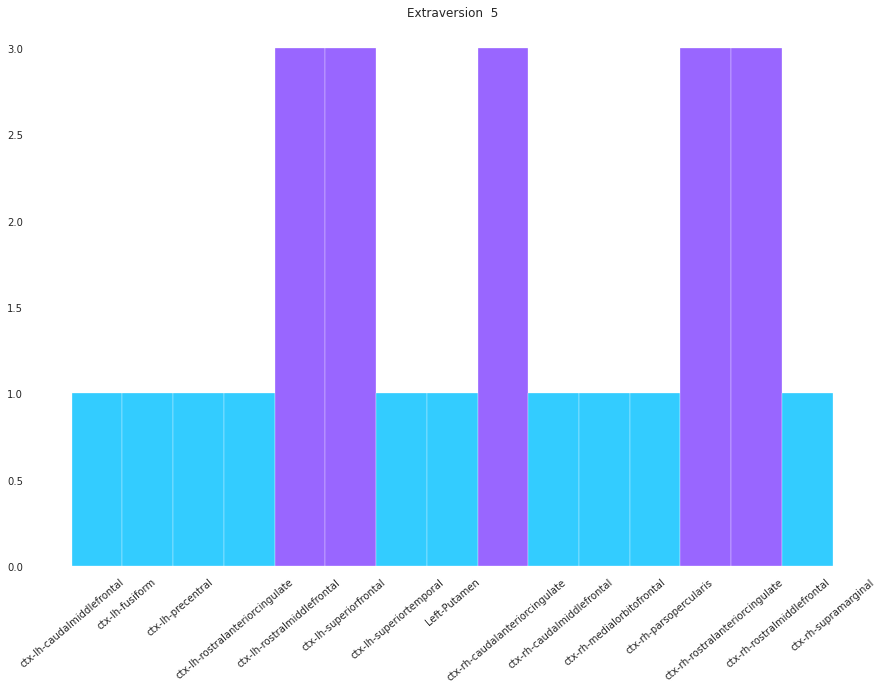

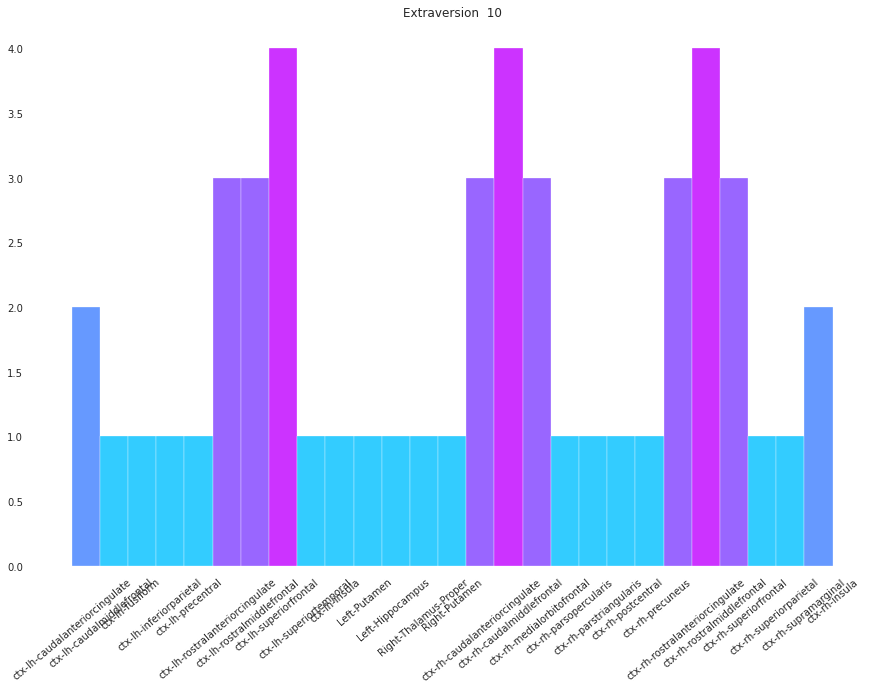

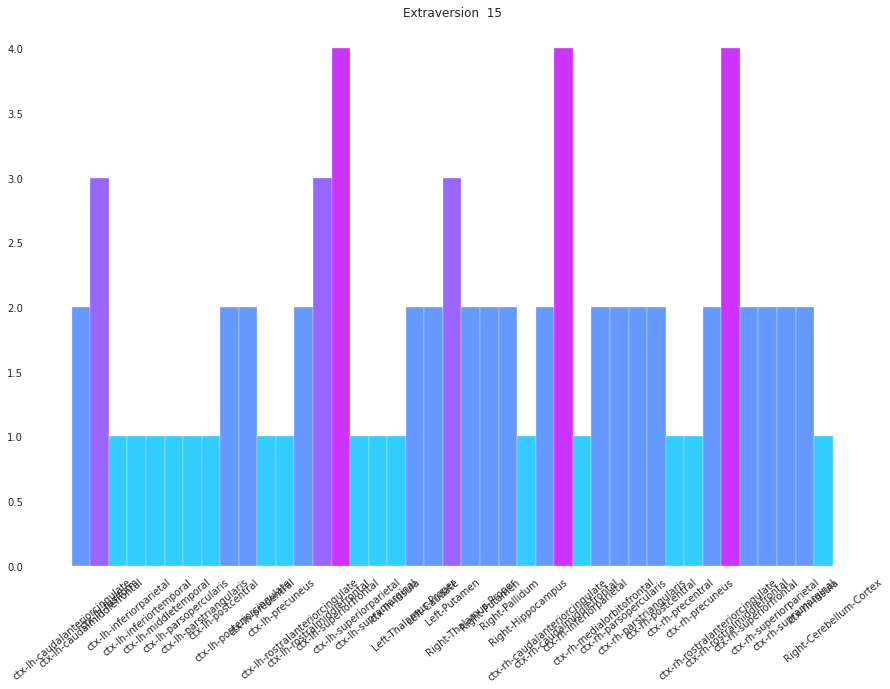

In [9]:

for num,i in zip(nodes_dict.keys(), range(len(nodes_dict.keys()))):
    a = np.sort(np.concatenate(nodes_dict[num]).flat)

    d1 = {k-1:v for k,v in corresp_label_file('fs_default.txt').items() if k-1 in np.unique(a)}

    d2 = {}
    for k,v in zip(range(len(np.unique(a))), np.unique(a)):
        d2[v] = k

    for i in range(len(a)):
        a[i] = d2[a[i]]
    cm = plt.cm.get_cmap('cool')

    fig, ax = plt.subplots(figsize=(15,10))
    counts, bins, patches = ax.hist(a, bins=len(np.unique(a)))
    for c, p in zip(counts, patches):
        plt.setp(p, 'facecolor', cm(c/5))
    # Set the ticks to be at the edges of the bins.
    plt.title(f'Extraversion  {num}')
    plt.xticks(range(len(np.unique(a))),list(d1.values()), rotation=40)
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from numpy.linalg import norm
i = 0
param_grid ={'alpha':[1e-1, 1, 1e-4, 1e-5, 10, 100, 1e3, 1e4, 1e5, 1e7]}

for train_index, test_index in skf.split(X, y):
    i+=1
    #print("TRAIN:",len(train_index), train_index, "TEST:", len(test_index),test_index)
    if i==4:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test, output_graph = solver_pub(X_train, X_test, y_train, 
                                                       strls_num_l,feature, thresh,val,
                                                            15, avg_thresh,
                                                        node_wts=solver_node_wts, target=target,edge=edge,keep_files=True)
        print(len(X_train.iloc[1,:]))                  
        nodes.append(list(output_graph.nodes))
        print(output_graph.filename)
        node_names.append(output_graph.node_labels)
        edge_wts = output_graph.edge_weights
        #model = GridSearchCV(Ridg(), param_grid, iid=True, scoring='r2')
        #lr = LinearRegression()
        rss_total = []
        sn_total = []
        for alpha in param_grid['alpha']:
            model = Ridge(alpha = alpha)
            model.fit(X_train, y_train) 
            pred= model.predict(X_train)
            rss_total.append(np.sqrt(sum((pred - y_train)**2)))
            sol =  list(model.coef_)
            sol.append(model.intercept_)
            sol = norm(sol)
            sn_total.append(sol)
            y_pred = model.predict(X_test)
            print(r2_score(y_test, y_pred))

75
NEOFAC_E_pearson_15_num_streamlines_0
-0.6855253291622154
-0.6517356073329648
-0.6895490038566892
-0.6895526586254748
-0.4213420082819843
0.0018446111924773634
0.05531106411266029
0.011612317339865341
-0.0002571376014430804
-0.0017801088968292245


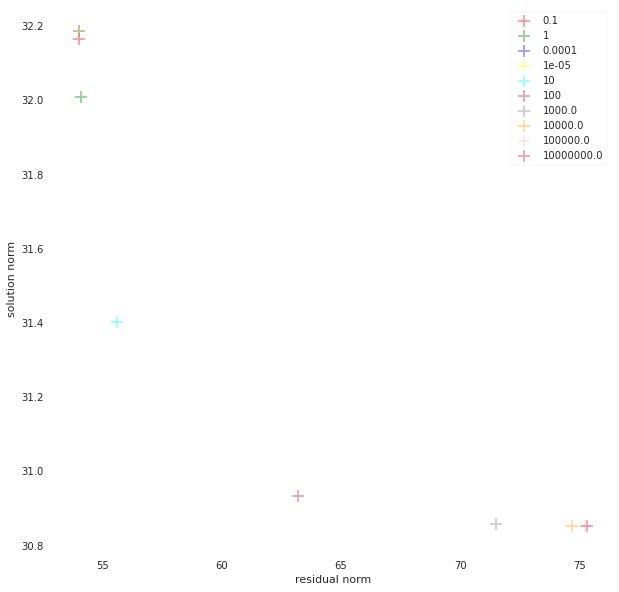

In [21]:
c = {}
fig, ax = plt.subplots(figsize = (10,10))
colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'brown', 'grey', 'orange', 'pink', 'crimson']
for k, color, rss, sn in zip(param_grid['alpha'], colors, rss_total, sn_total): 
    c[k] = color
    plt.scatter(rss, sn, color=color, alpha = 0.4, marker = '+', s=150)

plt.legend(param_grid['alpha'])
plt.xlabel('residual norm')
plt.ylabel('solution norm')
plt.show()

In [17]:
norm(y_train)

401.034911198514